In [24]:
import os
import torch
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt
import mlflow

from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [25]:

# Read data, convert to PyTorch tensors
data_samples = "lidar.csv"
data = pd.read_csv(data_samples, header=None)
X = data.iloc[:, 0:16].values
y = data.iloc[:, 16].values

trainingSetX = torch.tensor(X, dtype=torch.float32)
trainingSetY = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)

In [26]:

# use Cuda Y/N 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cpu device


In [27]:

#Neural Network construction
class NeuralNetwork(nn.Module):
    def __init__(self, inputs, outputs):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(inputs, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, outputs),
            
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [28]:


#model Training


model = NeuralNetwork(16, 1)

epochs = 250
batch_size = 64
learningRate = 0.0008
losses = []

lossFunction = nn.MSELoss()
gradientDescent = torch.optim.Adam(model.parameters(), lr=learningRate)

loader = DataLoader(
    dataset=torch.utils.data.TensorDataset(trainingSetX, trainingSetY),
    batch_size=batch_size,
    shuffle=True
)



for epoch in range(epochs):
    epoch_loss = 0.0
    for x, y in loader:
       
        gradientDescent.zero_grad()
        yhat = model(x)
        loss = lossFunction(yhat, y)
        epoch_loss += loss.item()
        loss.backward()
        gradientDescent.step()
    losses.append(epoch_loss / len(loader))




In [29]:
#Machine Learning Flow

sensor = "lidar"
hidden_layers = "64_32"
activation = "ReLU_ReLU"
batch_size = "64"

mlflow.set_experiment('NeuralNetwork')

# with mlflow.start_run(run_name=f'Neural net ({sensor}) | layers: {len(hidden_layers)}, epochs: {epochs}, lr: {lr}, batchsize: {batch_size}'):
with mlflow.start_run(run_name=f'NN({sensor}) {hidden_layers}, epochs: {epochs}, lr: {learningRate}, batch_size =    {batch_size}'):


    mlflow.log_param('sensor', sensor)
    mlflow.log_param('data_samples', data_samples)
    
    mlflow.log_param('hidden_layers', hidden_layers)
    mlflow.log_param('activation', activation)

    mlflow.log_param('epochs', epochs)
    mlflow.log_param('lr', learningRate)
    mlflow.log_param('batch_size', batch_size)

    mlflow.log_param('optimizer', gradientDescent)
    mlflow.log_param('loss_fn', lossFunction)
    mlflow.log_metric('losses', losses[-1])


In [30]:
# Saving Model
with open('SDCar_Lidar.pth', 'wb') as f:
    torch.save(model.linear_relu_stack, f)

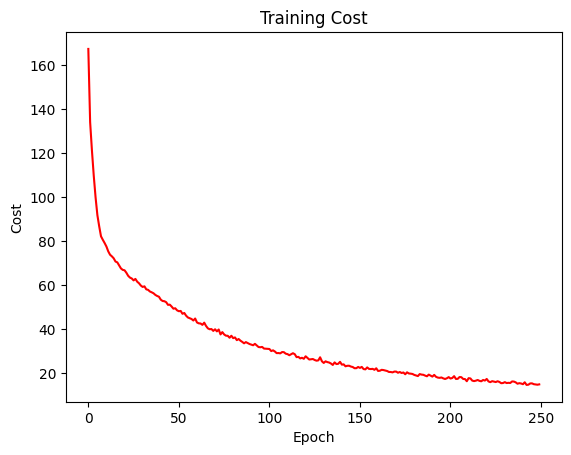

In [31]:
# Compare
fig, ax = plt.subplots()
ax.set(xlabel='Epoch', ylabel='Cost', title="Training Cost")
plt.plot([x for x in range(epochs)], losses, 'red')
plt.show()